In [1]:
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
from PIL import Image 
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
# import albumentations as aug

c:\aryan\Cracks\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

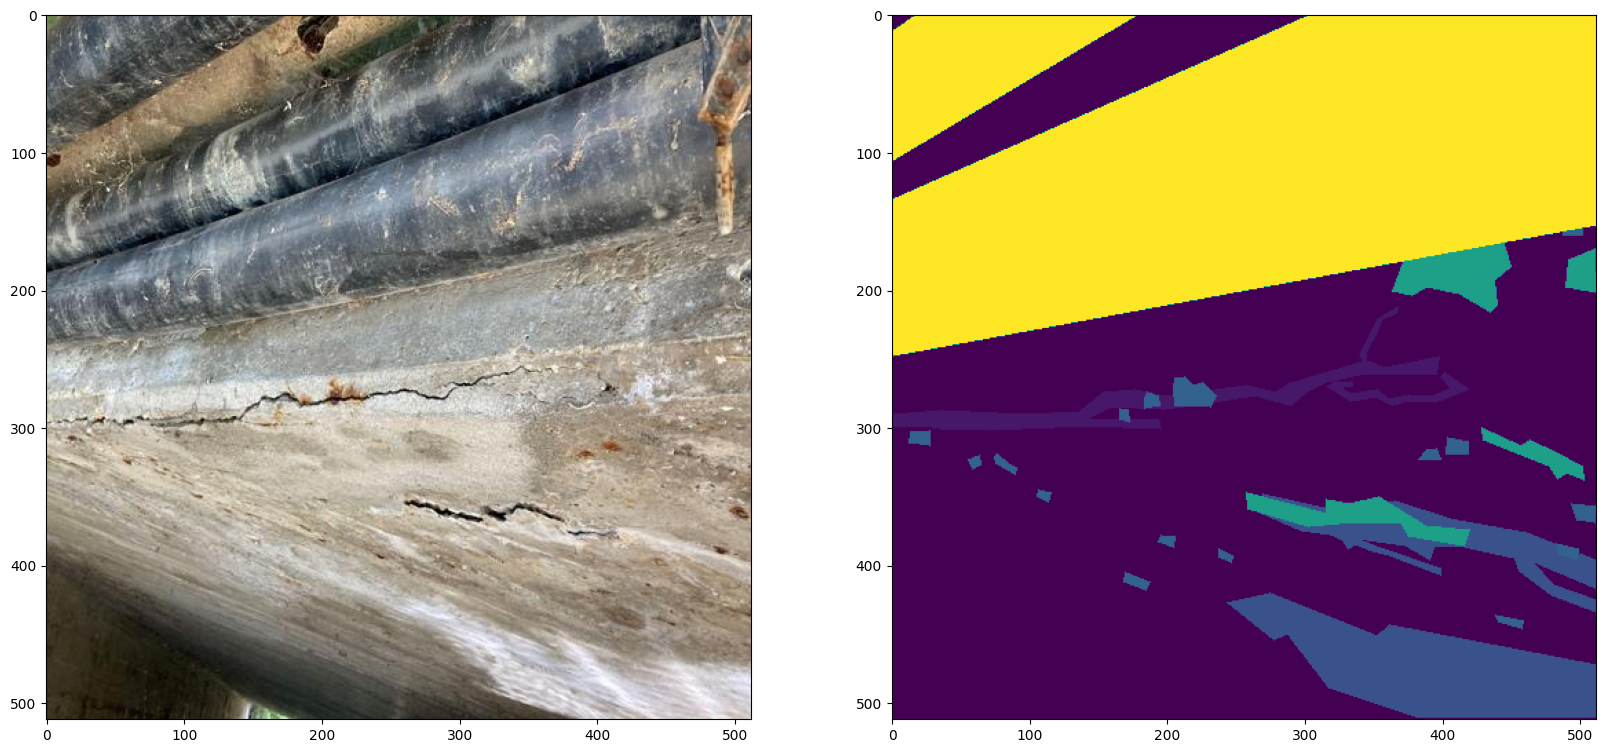

In [11]:
image = Image.open(r'C:\aryan\Cracks\data\dacl10k_v2_devphase\resized\data\data_megazord\images\validation\dacl10k_v2_validation_0130.jpg')
mask = Image.open(r'C:\aryan\Cracks\data\dacl10k_v2_devphase\resized\data\data_megazord\annotations\validation\dacl10k_v2_validation_0130.png').convert('L')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()

## Calcultaing mIOU

### mIOU for a Single Image (Testing)

In [4]:
from PIL import Image
import numpy as np

def read_mask_multiclass(image_path):
    mask_image = Image.open(image_path)
    
    # Convert to grayscale
    mask_image = mask_image.convert("L")
    
    mask_array = np.array(mask_image)
    return mask_array

def calculate_iou(gt_mask, pred_mask):
    intersection = np.logical_and(gt_mask, pred_mask)
    union = np.logical_or(gt_mask, pred_mask)

    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0.0
    print("iou: ", iou)
    return iou

def calculate_miou(gt_masks, pred_masks):
    unique_classes = np.unique(gt_masks)
    
    # Exclude class zero
    unique_classes = unique_classes[unique_classes != 0]
    
    class_ious = []

    for class_id in unique_classes:
        gt_class_mask = gt_masks == class_id
        pred_class_mask = pred_masks == class_id

        iou = calculate_iou(gt_class_mask, pred_class_mask)
        class_ious.append(iou)

    miou = np.mean(class_ious) if len(class_ious) > 0 else 0.0
    return miou

# Example usage:
# Replace 'path/to/gt_mask.png' and 'path/to/pred_mask.png' with the actual paths to your ground truth and predicted mask images
gt_mask_path = r'C:\aryan\Cracks\data\dacl10k_v2_devphase\resized\640x640\seg_maps_aug\validation\dacl10k_v2_validation_0544.png'
pred_mask_path = r'C:\aryan\Cracks\data\dacl10k_v2_devphase\resized\640x640\data_megazord\predictions\dacl10k_v2_validation_0544.png'

gt_mask = read_mask_multiclass(gt_mask_path)
print("Unique values in the gt_mask:", np.unique(gt_mask))
print("gt_mask shape:", gt_mask.shape)

pred_mask = read_mask_multiclass(pred_mask_path)
print("Unique values in the pred_mask:", np.unique(pred_mask))
print("pred_mask shape:", pred_mask.shape)

miou = calculate_miou(gt_mask, pred_mask)
print(f"Mean IoU (excluding class zero): {miou}")

Unique values in the gt_mask: [10]
gt_mask shape: (640, 640)
Unique values in the pred_mask: [0 1 2]
pred_mask shape: (640, 640)
iou:  0.0
Mean IoU (excluding class zero): 0.0


### mIOU for all Predictions

In [6]:
import os

# Path to the predicted and validation folders
predicted_folder = 'C:/aryan/Cracks/data/dacl10k_v2_devphase/resized/640x640/data_megazord/predictions'
# predicted_folder = 'C:/aryan/Cracks/data/dacl10k_v2_devphase/resized/data/data_megazord/readjusted_prediction'

validation_folder = 'C:/aryan/Cracks/data/dacl10k_v2_devphase/resized/640x640/seg_maps_aug/validation'

# Get a list of all files in the predicted folder
predicted_files = os.listdir(predicted_folder)

# Initialize a list to store mean IoU values for each image pair
mean_ious = []

# Loop through each predicted file
for predicted_file in predicted_files:

    if "horizontal" in predicted_file.lower() or "vertical" in predicted_file.lower():
        # print(f"Ignoring file: {predicted_file}")
        continue

    # Construct the paths for the current pair of images
    gt_mask_path = os.path.join(validation_folder, predicted_file)
    pred_mask_path = os.path.join(predicted_folder, predicted_file)

    # Check if the corresponding ground truth mask exists
    if os.path.exists(gt_mask_path):
        # Read masks
        gt_mask = read_mask_multiclass(gt_mask_path)
        pred_mask = read_mask_multiclass(pred_mask_path)

        # Calculate mean IoU
        miou = calculate_miou(gt_mask, pred_mask)
        
        if miou is not None:
            print(f"Mean IoU for {predicted_file}: {miou}")
            mean_ious.append(miou)

# Calculate the overall mean IoU across all images
overall_mean_iou = np.mean(mean_ious)
print(f"Overall Mean IoU: {overall_mean_iou}")


iou:  0.21670199781589258
Mean IoU for dacl10k_v2_validation_0000.png: 0.21670199781589258
iou:  0.0
iou:  0.9277560061339241
Mean IoU for dacl10k_v2_validation_0001.png: 0.46387800306696203
iou:  0.8076952188722089
iou:  0.0
Mean IoU for dacl10k_v2_validation_0002.png: 0.4038476094361044
iou:  0.8444813590871872
iou:  0.0005064573309698658
iou:  0.0
Mean IoU for dacl10k_v2_validation_0003.png: 0.28166260547271904
iou:  0.8045555247853781
iou:  0.8770550156454363
Mean IoU for dacl10k_v2_validation_0004.png: 0.8408052702154072
iou:  0.23404993733731805
Mean IoU for dacl10k_v2_validation_0005.png: 0.23404993733731805
iou:  0.0
iou:  0.0
iou:  0.0
Mean IoU for dacl10k_v2_validation_0006.png: 0.0
iou:  0.8616539146070714
Mean IoU for dacl10k_v2_validation_0007.png: 0.8616539146070714
iou:  0.11171321383909963
iou:  0.0
Mean IoU for dacl10k_v2_validation_0008.png: 0.055856606919549814
iou:  0.8783505154639175
iou:  0.0
iou:  0.0
Mean IoU for dacl10k_v2_validation_0009.png: 0.292783505154639

### mIOU for classes

In [4]:
import os

def calculate_class_miou_for_folder(gt_folder, pred_folder):
    # Get a list of all image files in the prediction folder
    pred_files = os.listdir(pred_folder)

    # Initialize a dictionary to accumulate class-wise IoU values
    class_ious_accumulated = {}

    # Iterate over each prediction file
    for pred_file in pred_files:
        if "horizontal" in pred_file.lower() or "vertical" in pred_file.lower():
        # print(f"Ignoring file: {predicted_file}")
            continue
        
        # Construct the paths for the current prediction image
        pred_path = os.path.join(pred_folder, pred_file)

        # Extract the base filename without extension
        base_filename = os.path.splitext(pred_file)[0]

        # Construct the path for the corresponding ground truth image
        gt_file = f"{base_filename}.png"  # Assuming the ground truth images have the same filenames with .png extension
        gt_path = os.path.join(gt_folder, gt_file)

        # Check if the ground truth file exists for the current prediction file
        if os.path.exists(gt_path):
            # Read the masks
            gt_mask = read_mask_multiclass(gt_path)
            pred_mask = read_mask_multiclass(pred_path)

            # Calculate class-wise IoU for the current image
            class_ious = calculate_specific_class_miou(gt_mask, pred_mask)

            # Accumulate the IoU values for each class
            for class_id, iou in class_ious.items():
                if class_id not in class_ious_accumulated:
                    class_ious_accumulated[class_id] = []
                class_ious_accumulated[class_id].append(iou)
        else:
            print(f"Warning: Ground truth file not found for prediction file '{pred_file}'. Skipping.")

    # Calculate the mean IoU for each class
    class_means = {}
    for class_id, iou_values in class_ious_accumulated.items():
        mean_iou = np.mean(iou_values)
        class_means[class_id] = mean_iou

    return class_means

# Example usage:
# Replace 'path/to/gt_folder' and 'path/to/pred_folder' with the actual paths to your ground truth and predicted mask folders
gt_folder_path = 'C:/aryan/Cracks/data/dacl10k_v2_devphase/resized/640x640/seg_maps_aug/validation'
pred_folder_path = 'C:/aryan/Cracks/data/dacl10k_v2_devphase/resized/640x640/data_megazord/predictions'

class_means = calculate_class_miou_for_folder(gt_folder_path, pred_folder_path)

# Print or use the mean IoU values for each class
for class_id, mean_iou in class_means.items():
    print(f"Class {class_id}: Mean IoU = {mean_iou}")


iou:  0.21670199781589258
iou:  0.0
iou:  0.9277560061339241
iou:  0.8076952188722089
iou:  0.0
iou:  0.8444813590871872
iou:  0.0005064573309698658
iou:  0.0
iou:  0.8045555247853781
iou:  0.8770550156454363
iou:  0.23404993733731805
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.8616539146070714
iou:  0.11171321383909963
iou:  0.0
iou:  0.8783505154639175
iou:  0.0
iou:  0.0
iou:  0.7252104208416834
iou:  0.1709751434034417
iou:  0.8848329987223946
iou:  0.0
iou:  0.03838231799096887
iou:  0.3877551020408163
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.7054930509596293
iou:  0.4522063553325614
iou:  0.0
iou:  0.7990535129231889
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.16783493201222727
iou:  0.0037094452441590077
iou:  0.0
iou:  0.5916939582819781
iou:  0.8138877674606378
iou:  0.0
iou:  0.7835290550400182
iou:  0.0
iou:  0.0
iou:  0.5441399168177455
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.53584229390681
iou:  0.0
iou:  0.6419753086419753
iou:  0.0
iou:  